In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter
from tqdm import tqdm
import torch
from torch import nn
from scipy.stats import norm
from sklearn.model_selection import train_test_split

## Reproduces Figs 6, 9, 10

In [ ]:
## We skip Fig 5 because it's only a snapshot of the first arriving wave.

### Load and process synthetic waveforms

In [81]:
synthetic_wfs = np.load('data/synthetic/synthetic_waveform_gathers.npy')
print(synthetic_wfs.shape)
dt = 0.004


(19738, 8, 1024)


373


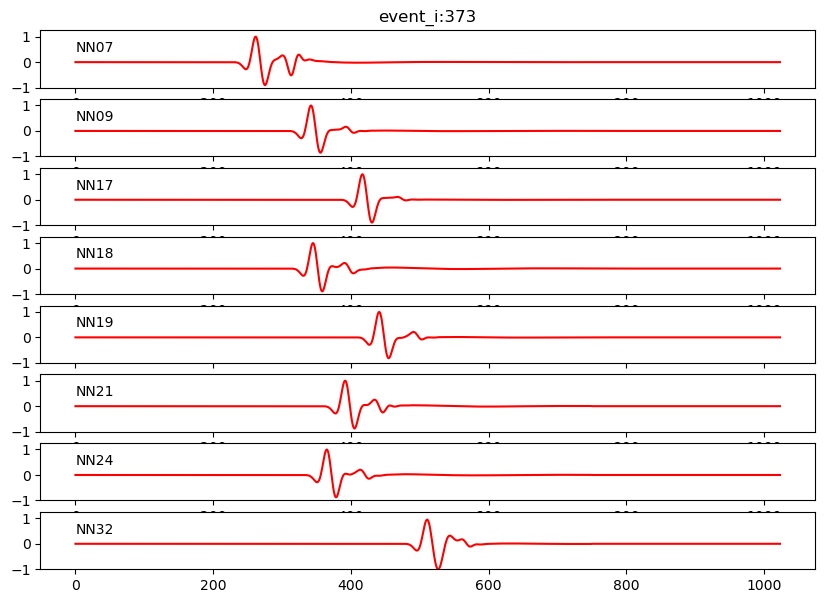

In [24]:
#### View some synthetic waveforms

station_IDs = ['NN07', 'NN09', 'NN17', 'NN18', 'NN19', 'NN21', 'NN24', 'NN32']
N = np.random.randint(len(synthetic_wfs))
N = 373
print(N)
fig,axs = plt.subplots(8,1,figsize=(10,7))
for i in range(8):
    ax = axs[i]
    stationID = station_IDs[i]
    ax.plot(synthetic_wfs[N,i],color='Red')
    ax.set_yticks(np.arange(-1,1.5,1))
    ax.text(0.02,0.4,'{}'.format(stationID))
    ax.set_ylim(-1,1.25)
    if i ==0:
        ax.set_title('event_i:{}'.format(N))


In [82]:
## Compute cross-correlation time lags

def preprocess(waveforms):

    raw_loc_ones = []
    raw_delta = []
    raw_xcorr = []
    raw_timelag = []
    raw_FA = [] #added 5/21
    for ea in tqdm(range(len(waveforms))):
        #use threshold method - to find first arrival
        f = []
        for i in range(8):
            sample = waveforms[ea,i]
            sample_abs = abs(sample)
            t = np.where(sample_abs>0.02)[0][0]
            f.append(t)
        f = np.array(f)
        raw_FA.append(f)

        #make delta
        delta = np.zeros((8,1024))
        for i in range(8):
            delta[i,f[i]] = 1
        raw_delta.append(delta)

        #compute cross correlation
        master_tr = delta[2].copy()
        xcorr = []
        for i in range(8):
            dat = np.correlate(master_tr,delta[i],'same')
            dat = dat/np.max(abs(dat))
            xcorr.append(dat)
        xcorr = np.array(xcorr)
        raw_xcorr.append(xcorr)

        #extract where ones
        loc_one = []
        for i in range(8):
            sample = xcorr[i]
            loc = np.where(sample==1)[0][0]
            loc_one.append(loc)
        loc_one = np.array(loc_one)
        raw_loc_ones.append(loc_one)

        #convert location of ones to time lag interms of *dt
        timelag_arr = loc_one-512
        timelag_arr = timelag_arr*dt
        raw_timelag.append(timelag_arr)

    raw_xcorr = np.array(raw_xcorr)
    raw_delta = np.array(raw_delta)
    raw_loc_ones = np.array(raw_loc_ones)
    raw_timelag = np.array(raw_timelag)
    raw_FA = np.array(raw_FA)

    return raw_xcorr,raw_delta,raw_loc_ones,raw_timelag,raw_FA


all_xcorr,all_delta,all_loc_ones,all_timelag,all_FA = preprocess(synthetic_wfs)

100%|██████████| 19738/19738 [00:12<00:00, 1590.95it/s]


### Create synthetic data for training, val, test

In [48]:
all_ev_locations = np.load('data/synthetic/synthetic_events_loc.npy')
print(all_ev_locations.shape)

(19738, 3)


In [49]:
#Train test split

X_Main, X_test, y_Main, y_test = train_test_split(all_timelag,all_ev_locations,random_state=155, test_size=0.05)
X_Train, X_Val, y_Train, y_Val = train_test_split(X_Main,y_Main,random_state=155, test_size=0.10)

print("X_Train's shape",X_Train.shape)
print("y_Train's shape",y_Train.shape)
print("X_Val's shape",X_Val.shape)
print("y_Val's shape",y_Val.shape)
print("X_test's shape",X_test.shape)
print("y_test's shape",y_test.shape)

print('TOTAL: ',X_Train.shape[0]+X_Val.shape[0]+X_test.shape[0])

X_Train's shape (16875, 8)
y_Train's shape (16875, 3)
X_Val's shape (1876, 8)
y_Val's shape (1876, 3)
X_test's shape (987, 8)
y_test's shape (987, 3)
TOTAL:  19738


In [ ]:
# np.save('data/for_DL/X_Train.npy',X_Train)
# np.save('data/for_DL/y_Train.npy',y_Train)
# np.save('data/for_DL/X_Val.npy',X_Val)
# np.save('data/for_DL/y_Val.npy',y_Val)
# np.save('data/for_DL/X_test.npy',X_test)
# np.save('data/for_DL/y_test.npy',y_test)

# Fig 6 - plot of first arrivals and cross correlation time lags

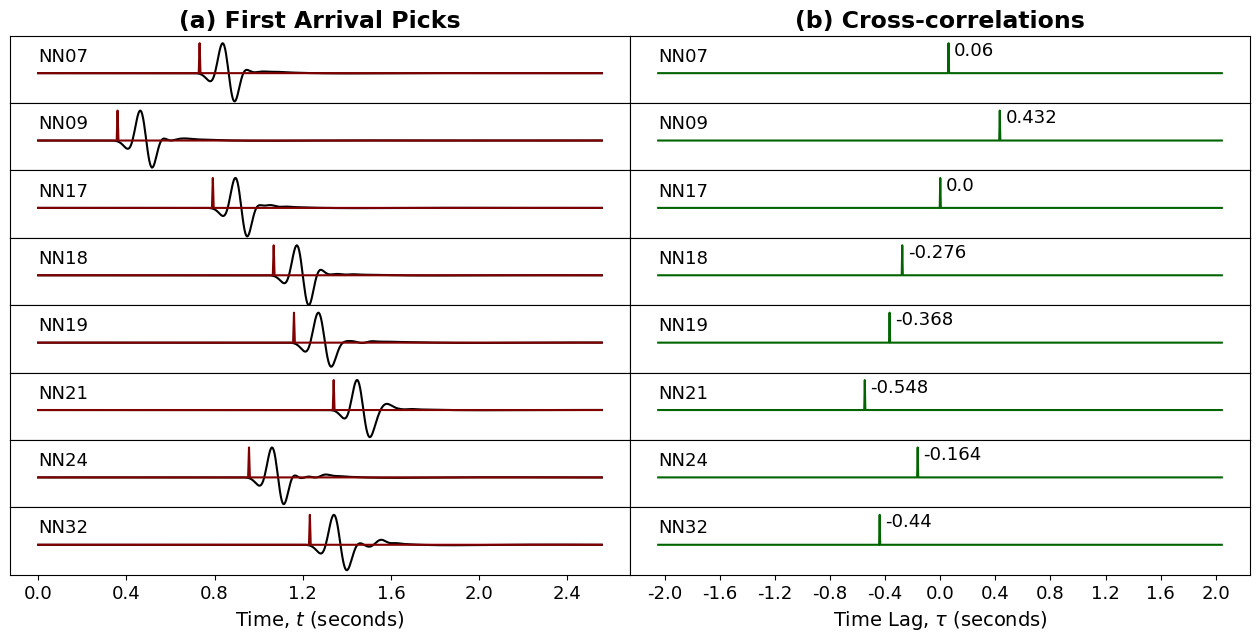

In [47]:
station_IDs = ['NN07', 'NN09', 'NN17', 'NN18', 'NN19', 'NN21', 'NN24', 'NN32']

r = 439
dt = 0.004
cut = 640
TimeLength = 1024
fig, axs = plt.subplots(8, 2, figsize=(16, 7), sharey='row')  # 2 columns for 2 sets of data

for i in range(8):
    stationID = station_IDs[i]
    
    # First arrival picks
    ax = axs[i, 0]
    ax.plot(synthetic_wfs[r, i, :cut], color='black')
    ax.plot(all_delta[r, i, :cut], color='maroon')
    ax.set_yticks(np.arange(-1, 1.5, 1))
    ax.set_ylim(-1, 1.25)
    ax.set_yticks([])
    ax.text(0.02, 0.4, '{}'.format(stationID), fontsize=13)

    # Title for the first subplot
    if i == 0:
        ax.set_title('(a) First Arrival Picks', fontsize=17,fontweight='heavy')

    # x-axis formatting
    if i != 7:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        xticks = np.arange(0, cut, 100)
        xticks_label = np.round(xticks*dt, 3)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks_label, fontsize=13)
        ax.set_xlabel(r'Time, $t$ (seconds)', fontsize=14)

    # Cross-correlations
    ax = axs[i, 1]
    ax.plot(all_xcorr[r, i], color='darkgreen')
    ax.set_yticks(np.arange(-1, 1.5, 1))
    ax.text(0.02, 0.4, '{}'.format(stationID), fontsize=13)

    # Title for the second subplot
    if i == 0:
        ax.set_title('(b) Cross-correlations', fontsize=17,fontweight='heavy')

    # x-axis formatting
    if i != 7:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        xticks = np.array([12,112, 212, 312, 412, 512, 612, 712, 812, 912,1012])
        xticks_label = np.round(xticks*dt-(1024*dt)/2, 2)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks_label, fontsize=13)
        ax.set_xlabel(r'Time Lag, $\tau$ (seconds)', fontsize=14)

    ax.set_ylim(-1, 1.25)
    ax.set_yticks([])
    ax.text(all_loc_ones[r, i]+10, 0.6, '{}'.format(all_timelag[r, i]), fontsize=13)

plt.subplots_adjust(wspace=0, hspace=0.0)
# plt.savefig('figures/6-Combined_Synthetic_Picks_and_XCorrs.jpg',dpi=300,bbox_inches='tight')


# Figure 9 - Training progress & sample predictions 

In [62]:
## Load PMLP model
class MyModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 1000)
        self.fc2 = nn.Linear(1000, 200)
        self.fc3_mean = nn.Linear(200, 2)
        self.fc3_mean_depth = nn.Linear(200,1)
        self.fc3_log_std = nn.Linear(200, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean_rest = self.fc3_mean(x)
        mean_depth = torch.relu(self.fc3_mean_depth(x))
        log_std = self.fc3_log_std(x)
        mean = torch.cat((mean_rest,mean_depth),axis=-1)

        return mean, log_std

## Prediction function
def predict(model, X, num_samples=1):
        with torch.no_grad():
            mean, log_std = model(X)
            std = torch.exp(log_std)
            
            # Sample from Gaussian distribution
            samples = torch.randn((num_samples, *mean.shape), device=mean.device) * std + mean
            
            # Return the average of samples
            return torch.mean(samples, dim=0)

def predict_uncertainties(model, X, num_samples=1):
        with torch.no_grad():
            mean, log_std = model(X)
            std = torch.exp(log_std)
            
            # Sample from Gaussian distribution
            samples = torch.randn((num_samples, *mean.shape), device=mean.device) * std + mean
            
            return samples

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"); print(device); print(torch.cuda.get_device_name())

def to_np(arr):
    return arr.detach().cpu().numpy()



cuda:0
NVIDIA GeForce RTX 4080


In [63]:
### Load Testing Data
X_test = np.load('data/for_DL/X_test.npy')
y_test = np.load('data/for_DL/y_test.npy')
X_test_torch = torch.tensor(X_test).to(device)
print(X_test_torch.shape)

torch.Size([987, 8])


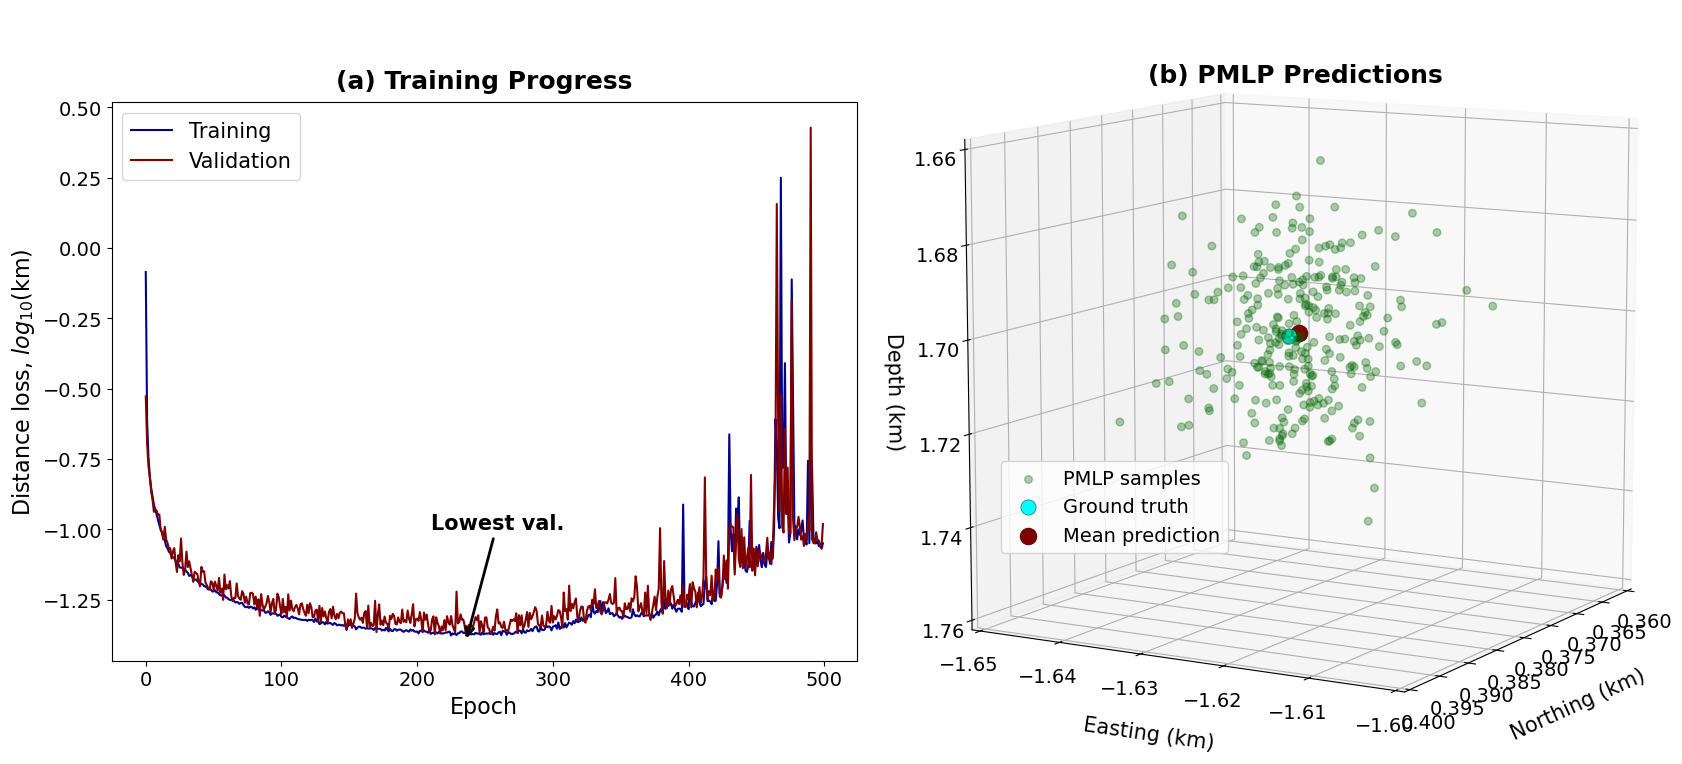

In [64]:

matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14

fig = plt.figure(figsize=(18,12))
# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
ax1 = fig.add_subplot(121)

############################################################# Training Progress #############################################################
training_log = np.load('weights_logs/GoodRun_Combined_log.npy',allow_pickle=True).item()
training_loss = training_log['loss']
val_loss = training_log['val_Loss']
lowest_val_idx = np.where(val_loss==np.min(val_loss))[0][0]
cut = 500
ax1.plot(np.log10(training_loss[:cut]),color='darkblue',label='Training')
ax1.plot(np.log10(val_loss[:cut]),color='maroon',label='Validation')
ax1.annotate('Lowest val.',xy=(lowest_val_idx,np.log10(0.04)),xytext=(210,-1.0),
            arrowprops = dict(arrowstyle='->',facecolor ='black',lw=2),fontsize=15,color='black',weight='bold');
# ax.set_xlim(,300)
# ax.set_ylim(0,0.3)
ax1.set_ylabel(r'Distance loss, $log_{10}$(km)',fontsize=16)
ax1.set_xlabel('Epoch',fontsize=16)
ax1.legend(fontsize=15)

ax1.set_box_aspect(aspect=0.75)
ax1.set_title('(a) Training Progress', weight='bold', fontsize=18,pad=10)

############################################################# Uncertainties #############################################################
ax2 = fig.add_subplot(122,projection='3d')
np.random.seed(123)
torch.manual_seed(123)

#Load stations
stations = np.load('data/stations/stENZ_DFS.npy')
stations = stations[-8:]

#pick
event_i = 405

## get uncertainties
PMLP_model = MyModel(8,3).to(device).double()
PMLP_model.load_state_dict(torch.load('weights_logs/GoodRun_Combined_LV.pth'))
sample_time_lag = X_test_torch[event_i][None,:].to(device)
def predict(model, X, num_samples=1):
        with torch.no_grad():
            mean, log_std = model(X)
            std = torch.exp(log_std)
            
            # Sample from Gaussian distribution
            samples = torch.randn((num_samples, *mean.shape), device=mean.device) * std + mean
            
            # Return the average of samples
            return torch.mean(samples, dim=0)
sample_prediction_all = np.squeeze(to_np(predict_uncertainties(PMLP_model,sample_time_lag,num_samples=300)))
sample_prediction = np.mean(sample_prediction_all,axis=0)



##uncertainties
ax2.scatter(sample_prediction_all[:,1],sample_prediction_all[:,0],sample_prediction_all[:,2], c='darkgreen', s=30,label='PMLP samples',alpha=0.32)
#ground truth
gt = y_test[event_i]
ax2.scatter(gt[1],gt[0],gt[2], 
            color='cyan', s=120,edgecolors='black',alpha=1,linewidth=0.3,label='Ground truth')
#prediction
ax2.scatter(sample_prediction[1],sample_prediction[0],sample_prediction[2], 
            color='maroon', s=150,edgecolors='black',alpha=1,linewidth=0.3,label='Mean prediction')


ax2.set_xlabel('Northing (km)', fontsize=15,labelpad=13)
ax2.set_ylabel('Easting (km)', fontsize=15,labelpad=13)
ax2.set_zlabel('Depth (km)', fontsize=15,labelpad=9)
ax2.view_init(elev=10,azim=30)
ax2.invert_zaxis()
ax2.legend(fontsize=14,loc=(0.1,0.27))
ax2.set_box_aspect(aspect=(1,1,1),zoom=1.1)
ax2.text(0.38, -1.645,1.65, '(b) PMLP Predictions', fontsize=18,weight='bold')



ax2.set_ylim(-1.65,-1.6)
ax2.set_xlim(0.36,0.4)
ax2.set_zlim(1.76,1.66)

fig.tight_layout(pad=5)
custom_bbox = matplotlib.transforms.Bbox([[0.5, 2.1], [17.5, 9.2]])

# plt.savefig('Figures/Combined_Uncert_Training_Progress_revise1.jpg',dpi=300,bbox_inches=custom_bbox)


# Figure 10 - Histogram of errors

In [69]:
def EarthDistanceLoss_np(prediction,ground_truth):
    '''
    distance formula
    input is [N,3]
    output is [N,3]
    '''
    if len(prediction.shape) == 1:
            prediction = prediction[None,:]
            ground_truth = ground_truth[None,:]

    distance_all = []
    for i in range(len(prediction)):
        predx = prediction[i,0] #(BS)
        predy = prediction[i,1] #(BS)
        predz = prediction[i,2] #(BS)
        
        gtx = ground_truth[i,0] #(BS)
        gty = ground_truth[i,1] #(BS)
        gtz = ground_truth[i,2] #(BS)

        distance = np.sqrt((predx-gtx)**2 + (predy-gty)**2 + (predz-gtz)**2)
        distance_all.append(distance)
    distance_all = np.array(distance_all)
    distance_all = np.mean(distance_all)

    return distance_all

In [76]:
X_test_torch = torch.tensor(X_test).to(device)
y_test_torch = torch.tensor(y_test).to(device)

print(X_test_torch.shape)

torch.manual_seed(34)

PMLP_model = MyModel(8,3).to(device).double()
PMLP_model.load_state_dict(torch.load('weights_logs/GoodRun_Combined_LV.pth'))

ypred_all = []
ind = np.random.randint(len(X_test))
for ind in range(len(X_test_torch)):

    select_Xtest = X_test_torch[ind][None,:]
    ypred_test = predict(PMLP_model,select_Xtest,num_samples=3000)
    ypred_test_np = np.squeeze(to_np(ypred_test))
    ypred_all.append(ypred_test_np)
ypred_all = np.array(ypred_all)
print(ypred_all.shape)

torch.Size([987, 8])
(987, 3)


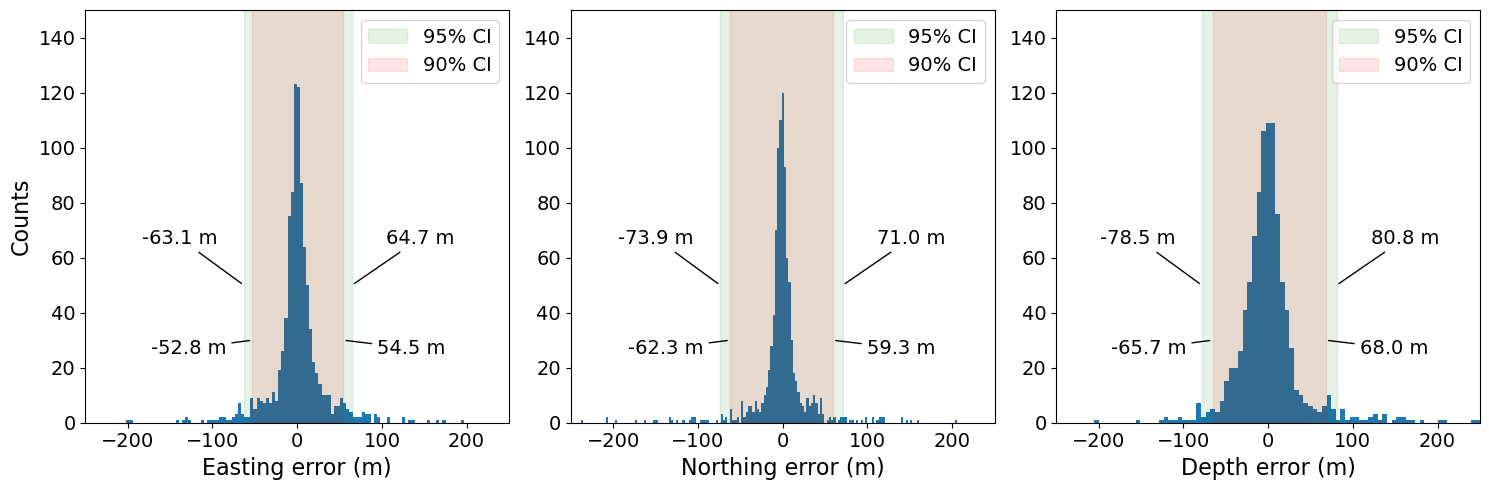

In [79]:
#check histogram of prediction

Easting_Error = (ypred_all[:,0] - y_test[:,0]) * 1000 #in meters
Northing_Error = (ypred_all[:,1] - y_test[:,1]) * 1000
Depth_Error = (ypred_all[:,2] - y_test[:,2]) * 1000

#confidence interval - 95%
CI_E_95 = norm(*norm.fit(Easting_Error)).interval(0.95)
CI_N_95 = norm(*norm.fit(Northing_Error)).interval(0.95)
CI_D_95 = norm(*norm.fit(Depth_Error)).interval(0.95)

#confidence interval - 90%
CI_E_90 = norm(*norm.fit(Easting_Error)).interval(0.90)
CI_N_90 = norm(*norm.fit(Northing_Error)).interval(0.90)
CI_D_90 = norm(*norm.fit(Depth_Error)).interval(0.90)


matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14

fig, axs = plt.subplots(1,3, figsize=(15,5))
bins = 'auto'
ax = axs[0]
ax.hist(Easting_Error,bins=bins,rwidth=1)
ax.fill_betweenx([0,220],CI_E_95[0], CI_E_95[1], color='g', alpha=0.1,label='95% CI')  
ci_l = np.round(CI_E_95[0],1)
ci_r = np.round(CI_E_95[1],1)
ax.annotate('{} m'.format(ci_l),xy=(ci_l,50),xytext=(ci_l-120,65), arrowprops = dict(arrowstyle='-',facecolor ='black'),fontsize=14,color='black');
ax.annotate('{} m'.format(ci_r),xy=(ci_r,50),xytext=(ci_r+40,65), arrowprops = dict(arrowstyle='-',facecolor ='black'),fontsize=14,color='black');         

ax.fill_betweenx([0,220],CI_E_90[0], CI_E_90[1], color='red', alpha=0.1,label='90% CI')  
ci_l = np.round(CI_E_90[0],1)
ci_r = np.round(CI_E_90[1],1)
ax.annotate('{} m'.format(ci_l),xy=(ci_l,30),xytext=(ci_l-120,25), arrowprops = dict(arrowstyle='-',facecolor ='black'),fontsize=14,color='black');
ax.annotate('{} m'.format(ci_r),xy=(ci_r,30),xytext=(ci_r+40,25), arrowprops = dict(arrowstyle='-',facecolor ='black'),fontsize=14,color='black');         
ax.set_xlabel('Easting error (m)',fontsize=16)
ax.set_ylabel('Counts',fontsize=16)
ax.set_ylim(0,150)
ax.set_xlim(-250,250)
ax.legend(fontsize=14)

ax = axs[1]
ax.hist(Northing_Error,bins=bins,rwidth=1)
ax.fill_betweenx([0,220],CI_N_95[0], CI_N_95[1], color='g', alpha=0.1,label='95% CI')  
ci_l = np.round(CI_N_95[0],1)
ci_r = np.round(CI_N_95[1],1)
ax.annotate('{} m'.format(ci_l),xy=(ci_l,50),xytext=(ci_l-120,65), arrowprops = dict(arrowstyle='-',facecolor ='black'),fontsize=14,color='black');
ax.annotate('{} m'.format(ci_r),xy=(ci_r,50),xytext=(ci_r+40,65), arrowprops = dict(arrowstyle='-',facecolor ='black'),fontsize=14,color='black');         
ax.fill_betweenx([0,220],CI_N_90[0], CI_N_90[1], color='red', alpha=0.1,label='90% CI')  
ci_l = np.round(CI_N_90[0],1)
ci_r = np.round(CI_N_90[1],1)
ax.annotate('{} m'.format(ci_l),xy=(ci_l,30),xytext=(ci_l-120,25), arrowprops = dict(arrowstyle='-',facecolor ='black'),fontsize=14,color='black');
ax.annotate('{} m'.format(ci_r),xy=(ci_r,30),xytext=(ci_r+40,25), arrowprops = dict(arrowstyle='-',facecolor ='black'),fontsize=14,color='black');         
ax.set_xlabel('Northing error (m)',fontsize=16)
ax.set_ylim(0,150)
ax.set_xlim(-250,250)
ax.legend(loc='upper right',fontsize=14)

ax = axs[2]
ax.hist(Depth_Error,bins=bins,rwidth=1)
ax.fill_betweenx([0,220],CI_D_95[0], CI_D_95[1], color='g', alpha=0.1,label='95% CI')  
ci_l = np.round(CI_D_95[0],1)
ci_r = np.round(CI_D_95[1],1)
ax.annotate('{} m'.format(ci_l),xy=(ci_l,50),xytext=(ci_l-120,65), arrowprops = dict(arrowstyle='-',facecolor ='black'),fontsize=14,color='black');
ax.annotate('{} m'.format(ci_r),xy=(ci_r,50),xytext=(ci_r+40,65), arrowprops = dict(arrowstyle='-',facecolor ='black'),fontsize=14,color='black');         
ax.fill_betweenx([0,220],CI_D_90[0], CI_D_90[1], color='red', alpha=0.1,label='90% CI')  
ci_l = np.round(CI_D_90[0],1)
ci_r = np.round(CI_D_90[1],1)
ax.annotate('{} m'.format(ci_l),xy=(ci_l,30),xytext=(ci_l-120,25), arrowprops = dict(arrowstyle='-',facecolor ='black'),fontsize=14,color='black');
ax.annotate('{} m'.format(ci_r),xy=(ci_r,30),xytext=(ci_r+40,25), arrowprops = dict(arrowstyle='-',facecolor ='black'),fontsize=14,color='black');         
ax.set_xlabel('Depth error (m)',fontsize=16)
ax.set_ylim(0,150)
ax.legend(fontsize=14)
fig.tight_layout()
ax.set_xlim(-250,250)

plt.savefig('figures/10-Synthetic_Histogram_Error_Combined.jpg',bbox_inches='tight',dpi=300)